# Human AI Interaction HW4
Here you will be using a generative adversarial network trained on [ImageNet](http://www.image-net.org/). Although there are many of non-dog classes in ImageNet, we will be focusing our experiments on dog photos. A high quality GAN is tricky to design well and takes dozens of hours or days to train, so to save ourselves computation time, we are using a pre-trained GAN with [TensorFlow](https://www.tensorflow.org/).

We recommend doing this assignment on colab since you can skip the installation of several libraries.

You will also use the text file `dog_classes.txt` for dog names.


## Frank Yue Ying | yying2@andrew.cmu.edu

# Part 1: Setting up
For this part, you just need to load the following code. 

## Loading libaries
This code uses TensorFlow version 1.15 and Python 3.
If you are trying to run this note book on Anaconda, you will need to be able to import all of the following libraries.

In [1]:
from io import BytesIO
import IPython.display
import numpy as np
import urllib
import PIL.Image
from scipy.stats import truncnorm
from skimage import io, data, transform # pip install scikit-image
import requests

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.framework import ops

import tensorflow_hub as hub
import scipy.misc
from tqdm import tqdm
import random
import cv2 # pip install opencv-python


Instructions for updating:
non-resource variables are not supported in the long term


## BigGAN Model Setup
For this exercise, we will use a pre-trained model called _BigGAN_ generator available on [TensorFlow Hub](https://tfhub.dev/deepmind/biggan-128/2). For more information about this model, check out the authors paper [_"Large Scale GAN Training for High Fidelity Natural Image Synthesis"_ Brock et al. 2019](https://arxiv.org/abs/1809.11096). Next is the address to download this model from TensorFlow Hub:

In [2]:
# this model will output 128 by 128 pixel images.
module_path ='https://tfhub.dev/deepmind/biggan-128/2'  
print(module_path)

https://tfhub.dev/deepmind/biggan-128/2


## Helper Code Setup

This following code is adapted from the [BigGANs Tutorial](https://colab.research.google.com/drive/1rqDwIddy0eunhhV8yrznG4SNiB5XWFJJ) from [Machine Learning for Artists](https://ml4a.github.io/) by Gene Kogan. Many of the exercises here are inspired from that tutorial, so check it out if you want to have more fun with GANs later!

In [3]:
class GANSession:
    def __init__(self, module_path):
        ops.reset_default_graph()
        print('Loading BigGAN module from:', module_path)
        self.module = hub.Module(module_path)
        self.inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
                       for k, v in self.module.get_input_info_dict().items()}
        self.output = self.module(self.inputs)

        print("\n")
        print('Inputs:\n', '\n'.join('  {}: {}'.format(*kv)
                                     for kv in self.inputs.items()))
        print("\n")
        print('Output:', self.output)

        self.input_z = self.inputs['z']
        self.input_y = self.inputs['y']
        self.input_trunc = self.inputs['truncation']

        self.dim_z = self.input_z.shape.as_list()[1]
        self.vocab_size = self.input_y.shape.as_list()[1]

        # Create a TensorFlow session and initialize variables
        initializer = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(initializer)

    def truncated_z_sample(self, batch_size, truncation=1., seed=None):
        state = None if seed is None else np.random.RandomState(seed)
        values = truncnorm.rvs(-2, 2, size=(batch_size,
                                            self.dim_z), random_state=state)
        return truncation * values

    def one_hot(self, index, vocab_size=None):
        if(not vocab_size):
            vocab_size = self.vocab_size
        index = np.asarray(index)
        if len(index.shape) == 0:
            index = np.asarray([index])
        assert len(index.shape) == 1
        num = index.shape[0]
        output = np.zeros((num, vocab_size), dtype=np.float32)
        output[np.arange(num), index] = 1
        return output

    def one_hot_if_needed(self, label, vocab_size=None):
        if(not vocab_size):
            vocab_size = self.vocab_size
        label = np.asarray(label)
        if len(label.shape) <= 1:
            label = self.one_hot(label, vocab_size)
        assert len(label.shape) == 2
        return label

    def sample(self, noise, label, truncation=1., batch_size=8, vocab_size=None):
        sess = self.sess
        if(not vocab_size):
            vocab_size = self.vocab_size
        noise = np.asarray(noise)
        label = np.asarray(label)
        num = noise.shape[0]
        if len(label.shape) == 0:
            label = np.asarray([label] * num)
        if label.shape[0] != num:
            raise ValueError('Got # noise samples ({}) != # label samples ({})'
                             .format(noise.shape[0], label.shape[0]))
        label = self.one_hot_if_needed(label, vocab_size)
        ims = []
        for batch_start in tqdm(range(0, num, batch_size)):
            s = slice(batch_start, min(num, batch_start + batch_size))
            feed_dict = {self.input_z: noise[s],
                         self.input_y: label[s], self.input_trunc: truncation}
            ims.append(sess.run(self.output, feed_dict=feed_dict))
        ims = np.concatenate(ims, axis=0)
        assert ims.shape[0] == num
        ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
        ims = np.uint8(ims)
        return ims

    def interpolate(self, A, B, num_interps):
        alphas = np.linspace(0, 1, num_interps)
        if A.shape != B.shape:
            raise ValueError(
                'A and B must have the same shape to interpolate.')
        return np.array([(1-a)*A + a*B for a in alphas])

    def imgrid(self, imarray, cols=5, pad=1):
        if imarray.dtype != np.uint8:
            raise ValueError('imgrid input imarray must be uint8')
        pad = int(pad)
        assert pad >= 0
        cols = int(cols)
        assert cols >= 1
        N, H, W, C = imarray.shape
        rows = int(np.ceil(N / float(cols)))
        batch_pad = rows * cols - N
        assert batch_pad >= 0
        post_pad = [batch_pad, pad, pad, 0]
        pad_arg = [[0, p] for p in post_pad]
        imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
        H += pad
        W += pad
        grid = (imarray
                .reshape(rows, cols, H, W, C)
                .transpose(0, 2, 1, 3, 4)
                .reshape(rows*H, cols*W, C))
        if pad:
            grid = grid[:-pad, :-pad]
        return grid

    def interpolate_and_shape(self, A, B, num_samples, num_interps):
        interps = self.interpolate(A, B, num_interps)
        return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                .reshape(num_samples * num_interps, -1))

    def get_interpolated_yz(self, categories_all, num_interps, noise_seed_A, noise_seed_B, truncation):
        nt = len(categories_all)
        num_samples = 1
        z_A, z_B = [self.truncated_z_sample(num_samples, truncation, noise_seed)
                    for noise_seed in [noise_seed_A, noise_seed_B]]
        y_interps = []
        for i in range(nt):
            category_A, category_B = categories_all[i], categories_all[(
                i+1) % nt]
            y_A, y_B = [self.one_hot([category] * num_samples)
                        for category in [category_A, category_B]]
            y_interp = self.interpolate_and_shape(
                np.array(y_A), np.array(y_B), num_samples, num_interps)
            y_interps.append(y_interp)
        y_interp = np.vstack(y_interps)
        z_interp = self.interpolate_and_shape(
            z_A, z_B, num_samples, num_interps * nt)

        return y_interp, z_interp

    def get_transition_yz(self, classes, num_interps, truncation):
        noise_seed_A, noise_seed_B = 10, 20   # fix this!
        return self.get_interpolated_yz(classes, num_interps, noise_seed_A, noise_seed_B, truncation=truncation)

    def get_random_yz(self, num_classes, num_interps, truncation):
        random_classes = [int(1000*random()) for i in range(num_classes)]
        return self.get_transition_yz(random_classes, num_interps, truncation=truncation)

    def get_combination_yz(self, categories, noise_seed, truncation):
        z = np.vstack([self.truncated_z_sample(1, truncation, noise_seed)]
                      * (len(categories)+1))
        y = np.zeros((len(categories)+1, 1000))
        for i, c in enumerate(categories):
            y[i, c] = 1.0
            y[len(categories), c] = 1.0
        return y, z

    def slerp(self, A, B, num_interps):  # see https://en.wikipedia.org/wiki/Slerp
        # each unit step tends to be a 90 degree rotation in high-D space, so this is ~360 degrees
        alphas = np.linspace(-1.5, 2.5, num_interps)
        omega = np.zeros((A.shape[0], 1))
        for i in range(A.shape[0]):
            tmp = np.dot(A[i], B[i]) / \
                (np.linalg.norm(A[i])*np.linalg.norm(B[i]))
            omega[i] = np.arccos(np.clip(tmp, 0.0, 1.0))+1e-9
        return np.array([(np.sin((1-a)*omega)/np.sin(omega))*A + (np.sin(a*omega)/np.sin(omega))*B for a in alphas])

    def slerp_and_shape(self, A, B, num_interps):
        interps = self.slerp(A, B, num_interps)
        return (interps.transpose(1, 0, *range(2, len(interps.shape)))
                .reshape(num_interps, *interps.shape[2:]))

    def imshow(self, a, format='png', jpeg_fallback=True):
        a = np.asarray(a, dtype=np.uint8)
        str_file = BytesIO()
        PIL.Image.fromarray(a).save(str_file, format)
        png_data = str_file.getvalue()
        try:
            disp = IPython.display.display(IPython.display.Image(png_data))
        except IOError:
            if jpeg_fallback and format != 'jpeg':
                print ('Warning: image was too large to display in format "{}"; '
                       'trying jpeg instead.').format(format)
                return self.imshow(a, format='jpeg')
            else:
                raise
        return disp


## Loading a BigGAN module

In [4]:
gan = GANSession(module_path)

Loading BigGAN module from: https://tfhub.dev/deepmind/biggan-128/2
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore




Inputs:
   z: Tensor("z:0", shape=(?, 120), dtype=float32)
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)


Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 128, 128, 3), dtype=float32)


# Part 2: Experimenting with generating deep fake puppies

**Task 2.A (5pt)** Choose a dog breed from `dog_classes.txt`, replacing the Corgi below.

truncation:  0.34322449547362377  noise seed: 26


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


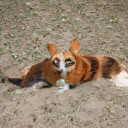

In [5]:
truncation = random.uniform(0.02,1) # min:0.02, max:1
noise_seed = random.randint(0,100) # min:0, max:100
category = "263: 'Pembroke, Pembroke Welsh corgi'" # put dog breed here

num_samples = 1
z = gan.truncated_z_sample(num_samples, truncation, noise_seed)
y = int(category.split(':')[0])

print('truncation: ',truncation, ' noise seed:',noise_seed)


ims = gan.sample(z, y, truncation=truncation) # ims is a numpy array
max_columns = 20
gan.imshow(gan.imgrid(ims, cols=min(num_samples, max_columns)))

**Task 2.B (5pt)** Run the above generator a few times. Below, paste in your best looking result as well as the `truncation` and `noise seed` parameter values for that result. Next paste in your worst looking dog as well as its parameter values. Describe what you are seeing: what kinds of visual errors do you think this model is creating? _hint: if you copy a screenshot to clipboard, you can paste it directly into this markdown cell_

**Answer:**

Best - truncation:  0.4492171475918766  noise seed: 100
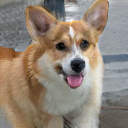
Worst - truncation:  0.37081595549520663  noise seed: 47
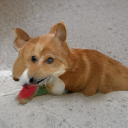

**Task 2.C (8pt)** Take the code from 2.A above and copy that below for task 2.C. Now adapt this code so that it generates a row of 11 dog images, where each dog has a different value of the parameter `noise_seed` evenly distributed across the range 0 to 100 inclusive.

_For a Welsh Pembroke Corgi with a fixed `truncation` value of `0.95` this looks like:_
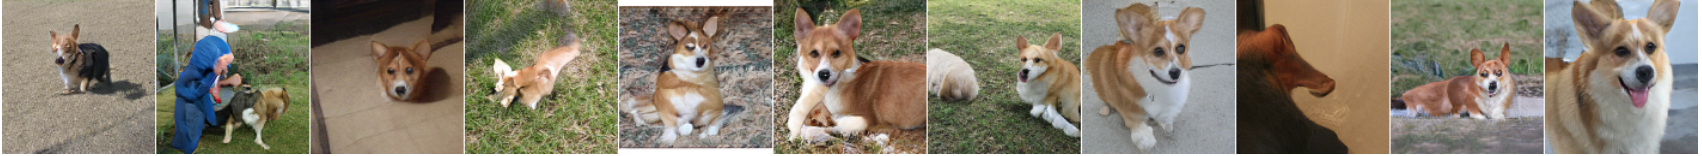
_where the leftmost Corgi has a `noise_seed` of `0` and the rightmost has a `noise_seed` of 100_

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


<Figure size 432x288 with 0 Axes>

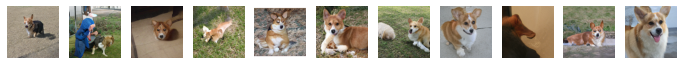

In [17]:
## Task 2.C
# reference https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib.pyplot as plt

number_of_files =11
truncation = 0.95
fig = plt.figure()
category = "263: 'Pembroke, Pembroke Welsh corgi'" # put dog breed here
def gen_corgi (noise_seed):
    z = gan.truncated_z_sample(1, truncation, noise_seed)
    y = int(category.split(':')[0])
    ims = gan.sample(z, y, truncation=truncation) # ims is a numpy array
    max_columns = 20
    return gan.imgrid(ims, cols=min(num_samples, max_columns))

fig, axarr = plt.subplots(nrows=1, ncols=11,figsize=(12,4))
for i in range(0,101,10):
    img = gen_corgi(i)
    index = int(i/10)
    plt.sca(axarr[index])
    imshow(img)
    axis('off')

**Task 2.D (12pt)** Take the code from 2.C above and copy that below. Now, your target output is a _grid_ of dogs. Just as before in 2.C, each _column_ will be 11 generated dogs in an ordered range by `noise_seed` 0-100. Now the _rows_ of the grid shall be different values of the `truncation` parameter, in an ordered range from 0.02-1.0. Your finished grid should have 10 rows, 11 columns, where the top left dog in the grid has a `noise_seed = 0` and `truncation = 0.02` and the values of those parameters increase top to bottom left to right. The dog at the bottom right will have a `noise_seed = 100` and `truncation = 1.0`.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


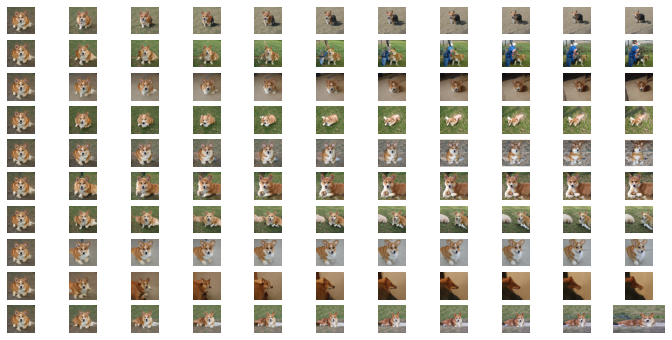

In [29]:
## Task 2.D
category = "263: 'Pembroke, Pembroke Welsh corgi'" # put dog breed here
def gen_corgi (noise_seed,truncation):
    z = gan.truncated_z_sample(1, truncation, noise_seed)
    y = int(category.split(':')[0])
    ims = gan.sample(z, y, truncation=truncation) # ims is a numpy array
    max_columns = 20
    return gan.imgrid(ims, cols=min(num_samples, max_columns))

fig, axarr = plt.subplots(nrows=10, ncols=11,figsize=(12,6))
for i in range(0,100,10):
    c_index = int(i/10)
    j = 0.02
    while j <= 1:
        img = gen_corgi(i,j)
        r_index = int(j/0.098)
        j+=0.098
        plt.sca(axarr[c_index][r_index])
        plt.imshow(img)
        axis("off")
plt.axis("off")
plt.axis("tight")
plt.show()

**Task 2.E (11pt)** Given your experimentations above and your grid of dogs, hypothesize:
 - What might be the relationship between `noise_seed` and what a generated dog looks like?
 - What might be the relationship between `truncation` and what a generated dog looks like?

**Answer:**
Higher Noise seed seems to add more non-dog elements into the picture, such as background and surroundings.  
Higher truncation leads to smaller dog in the picture and less clearer representation. 

# Part 3: Experimenting with transforming puppies

In this section, we will experiment with different forms of interpolation to transform and combine different dog images.

**Task 3.A (8pt)** Modify and run the code below, putting in your favorite `truncation` and `noise_seed` values from your experiments in Part 2. Run the code with a pair of closely similair breeds (like the Pembroke and the Cardigan Welsh corgies shown below) and a pair of very different breeds. 
 - What do you hypothesize this code is doing with the two dog image samples?
 - Hypothesize: Does the performance (visual quality of the output) differ based on qualities of the source images such as similar dog breed or similar image background?
 
**Answer:**

In [ ]:
num_interps = 10 #min:2, max:1000
truncation = 0.46 #min:0.02, max:1
noise_seed_A = 2 #min:0, max:100
category_A = "263: 'Pembroke, Pembroke Welsh corgi'" 
noise_seed_B = 99 #min:0, max:100
category_B = "264: 'Cardigan, Cardigan Welsh corgi'" 

y_interp, z_interp = gan.get_interpolated_yz([int(category_A.split(':')[0]), int(category_B.split(':')[0])], num_interps, noise_seed_A, noise_seed_B, truncation=truncation)
imgs = gan.sample(z_interp, y_interp, truncation=truncation)
gan.imshow(gan.imgrid(imgs, cols=num_interps))

The code below does a different, but similar operation to the code in Task 3.A.

**Task 3.B (8pt)** Modify and run the code below, putting in your favorite `truncation` and `noise_seed` values from your experiments in Part 2. Run the code with a pair of closely similair breeds (like the Pembroke and the Cardigan Welsh corgies shown below) and a pair of very different breeds. 
 - What do you hypothesize this code is doing with the two dog image samples?
 - Hypothesize: Does the performance (visual quality of the output) differ based on qualities of the source images such as similar dog breed or similar image background?
 - Unlike in Task 3.A, both images share the same `noise_seed`. From your observations, what do you think is the effect of having the images share the same parameter value versus having each their own `noise_seed`?
 
**Answer:**

In [ ]:
truncation = 0.45 #min:0.02, max:1
noise_seed = 22 #min:0, max:100
categoryA = "266: 'miniature poodle'" 
categoryB = "153: 'Maltese dog, Maltese terrier, Maltese'"  

categories = [int(categoryA.split(':')[0]), int(categoryB.split(':')[0])]
y, z = gan.get_combination_yz(categories, noise_seed, truncation)
imgs = gan.sample(z, y, truncation=truncation)
gan.imshow(gan.imgrid(imgs, cols=len(categories)+1))

**Task 3.C (5pt)** Paste in below your best looking result from 3.B. Include a description of all parameters you used to generate the image.

**Answer:**

**Task 3.D (5pt)** A big advantage of the BigGAN model over other GANs is that it is able to produce much higher resolution images than GANs were previously capable of. To test this out, go up to the Model Setup section, and replace the module path with ['https://tfhub.dev/deepmind/biggan-512/2']('https://tfhub.dev/deepmind/biggan-512/2'). Then re-run just the Setup section of this notebook. This will load a version of BigGAN that can generate 512 by 512 pixel images instead of 128 by 128 pixels.

Now re-run the code for Task 3.B, and paste in below your best looking result, including a description of all parameters. _note: since this generates a larger image, it will take longer to compute_

**Answer:**

**Task 3.E (8pt)** Compare your best results from Task 3.C and 3.D. Hypothesize, what do you think the effect of a higher resolution GAN is on the image quality?

**Answer:**